In [50]:
#!pip install dask
#!pip install xarray
#!pip install "dask[complete]"

import os
import json
import rasterio
import requests
import xarray as xr
from rasterio.merge import merge
from rasterio.plot import show


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nir_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B5.TIF'
red_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B4.TIF'
mtl_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_MTL.json'

In [3]:
def download_file(in_filename, out_filename):
    if not os.path.exists(out_filename):
        print("Downloading", in_filename)
        response = requests.get(in_filename)
        with open(out_filename, 'wb') as f:
            f.write(response.content)

In [4]:
download_file(nir_filename, 'nir.tif')
download_file(red_filename, 'red.tif')
download_file(mtl_filename, 'meta.json')

In [36]:
red = xr.open_rasterio('red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir = xr.open_rasterio('nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir

<xarray.DataArray (band: 1, y: 7841, x: 7721)>
dask.array<open_rasterio-634a88c0373673aa2a050512f61f8725<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 4.423e+06 4.423e+06 4.423e+06 ... 4.188e+06 4.188e+06
  * x        (x) float64 4.134e+05 4.134e+05 4.135e+05 ... 6.45e+05 6.45e+05
Attributes:
    transform:      (30.0, 0.0, 413385.0, 0.0, -30.0, 4423215.0)
    crs:            +init=epsg:32613
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

BoundingBox(left=413385.0, bottom=4187985.0, right=645015.0, top=4423215.0)
1


Text(0, 0.5, 'Row #')

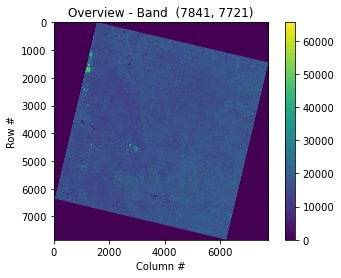

In [32]:
with rasterio.open('nir.tif') as src:
    print(src.bounds)
    print(src.count)
    thumbnail = src.read(1)
plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band  {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
    

Text(0, 0.5, 'Row #')

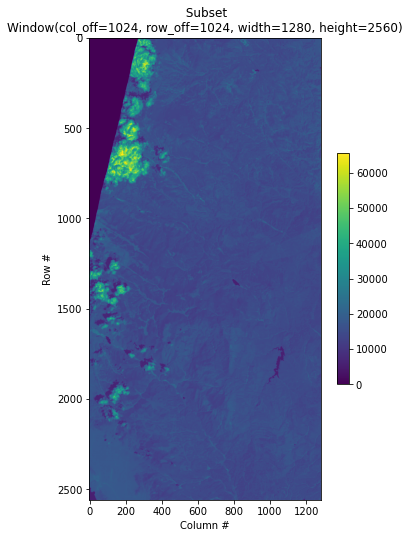

In [41]:
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

src_nir=rasterio.open('nir.tif') 
src_red=rasterio.open('red.tif') 
subset = src_nir.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f' Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')


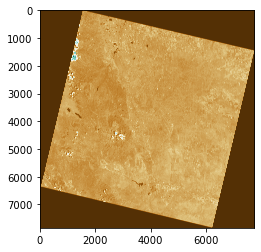

In [63]:
src_files_to_mosaic = [src_nir,src_red]
mosaic, out_trans = merge(src_files_to_mosaic)
show(mosaic,cmap='BrBG')

In [58]:
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans,
                  "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                  }
                 )
with rasterio.open('mosaic.tiff', "w", **out_meta) as dest:
     dest.write(mosaic)

Text(0, 0.5, 'Row #')

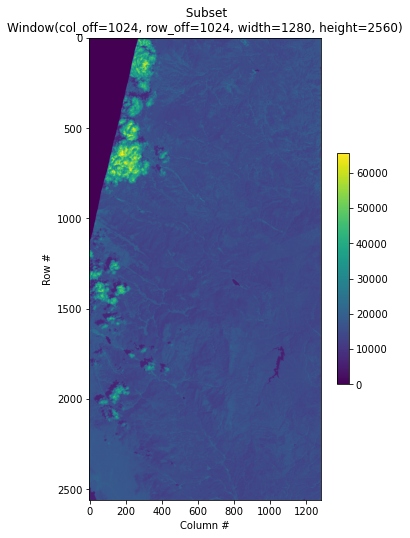

In [59]:
src_mosaic=rasterio.open('mosaic.tiff') 

subset = src_mosaic.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f' Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')